In [116]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
import pandas as pd
from scipy.spatial import ConvexHull
from sklearn.cluster import DBSCAN

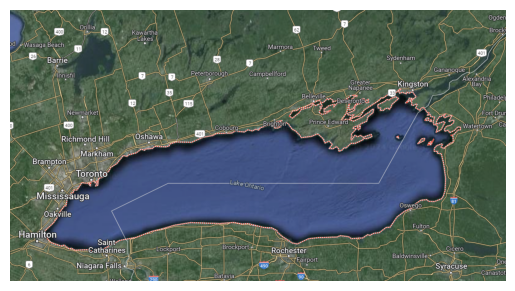

In [125]:
high_quality_path = "high_definition.png"
sample_image = cv2.cvtColor(cv2.imread(high_quality_path), cv2.COLOR_BGR2RGB)
plt.imshow(sample_image)
plt.axis('off')
plt.show()

In [126]:
sample_image_reshaped = sample_image / 255.0 # use 0...1 scale
sample_image_reshaped = sample_image_reshaped.reshape(sample_image.shape[0]* sample_image.shape[1], 3)
sample_image_reshaped.shape

(810522, 3)

In [31]:
def plot_pixels(image_reshaped, title, colors=None, N=10000):
    if colors is None:
        colors = image_reshaped

    # choose a random subset
    rng = np.random.RandomState(0)
    i = rng.permutation(image_reshaped.shape[0])[:N]
    colors = colors[i]
    R, G, B = image_reshaped[i].T

    fig = plt.figure(figsize=(10, 8))
    ax = fig.add_subplot(111, projection='3d')
    ax.scatter(R, G, B, c=colors, marker='.')
    ax.set(xlabel='Red', ylabel='Green', zlabel='Blue')
    ax.set_title(title)

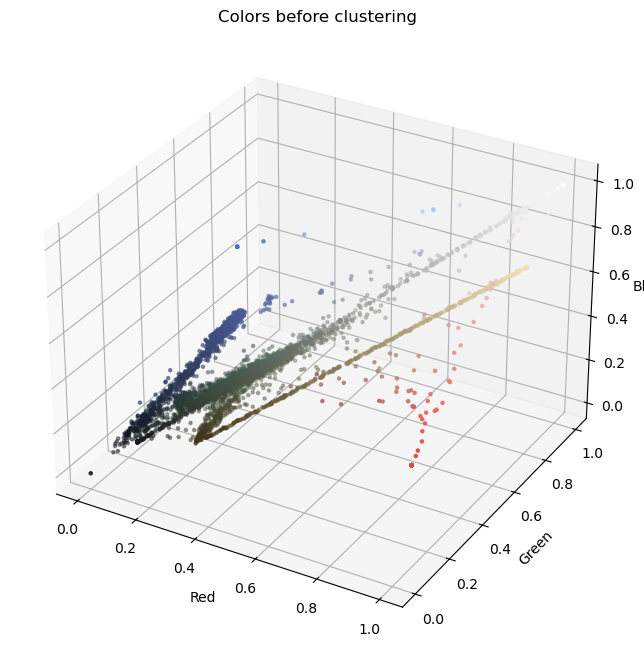

In [32]:
plot_pixels(sample_image_reshaped, title='Colors before clustering')

In [33]:
def plot_elbow_kmeans(data, k_max):
    scores = []
    for k in range(1, k_max):
        kmeans = KMeans(n_clusters=k)
        kmeans.fit(data)
        scores.append(kmeans.inertia_)
        

    plt.plot(range(1, k_max), scores)
    plt.xlabel('Number of clusters')
    plt.ylabel('Inertia')

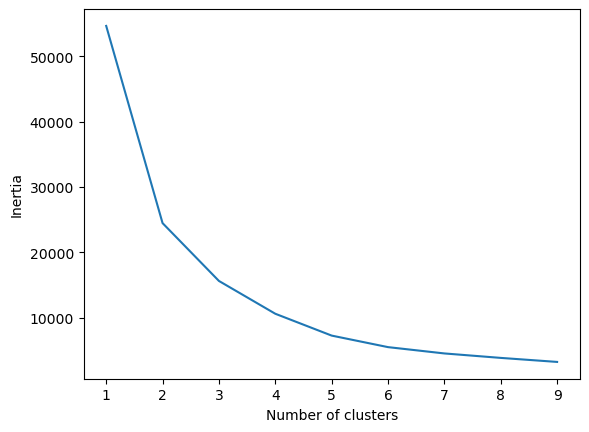

In [34]:
plot_elbow_kmeans(sample_image_reshaped, 10)

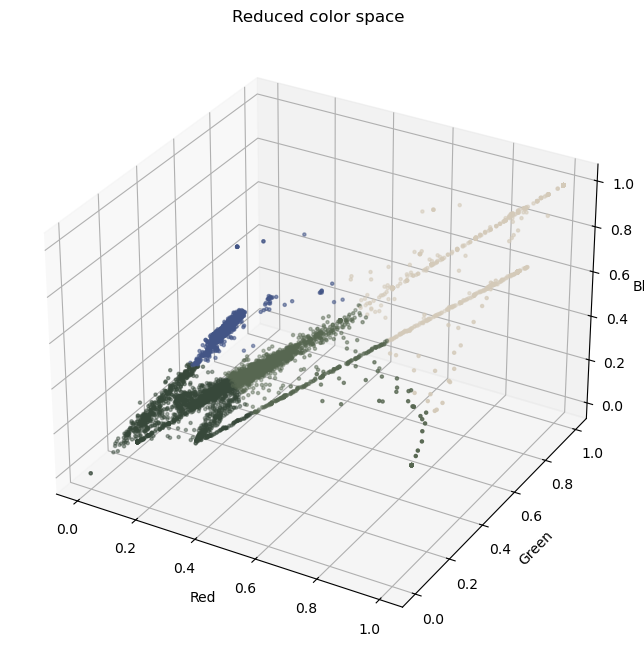

In [128]:
clusters_amount = 4
kmeans_dist = KMeans(clusters_amount, random_state=42).fit(sample_image_reshaped)
new_colors = kmeans_dist.cluster_centers_[kmeans_dist.predict(sample_image_reshaped)]

plot_pixels(sample_image_reshaped, colors=new_colors,
            title="Reduced color space")

Text(0.5, 1.0, 'Clustered image')

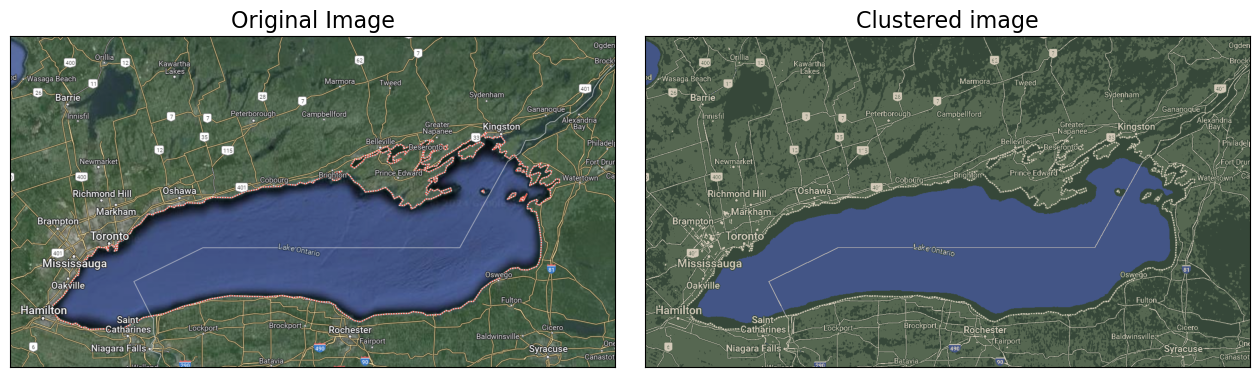

In [54]:
sample_image_color_clust = new_colors.reshape(sample_image.shape)

fig, ax = plt.subplots(1, 2, figsize=(16, 6),subplot_kw=dict(xticks=[], yticks=[]))
fig.subplots_adjust(wspace=0.05)
ax[0].imshow(sample_image)
ax[0].set_title('Original Image', size=16)
ax[1].imshow(sample_image_color_clust)
ax[1].set_title('Clustered image', size=16)

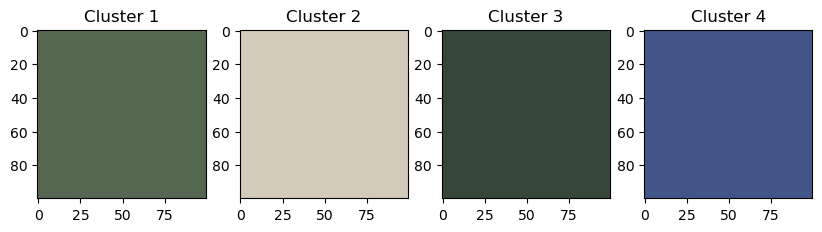

In [55]:
fig, axs = plt.subplots(1, clusters_amount, figsize=(10, 4))

for i in range(clusters_amount):
    cluster_color = kmeans_dist.cluster_centers_[i]
    cluster_image = np.ones((100, 100, 3)) * cluster_color
    axs[i].imshow(cluster_image)
    axs[i].set_title(f"Cluster {i+1}")

plt.show()

In [56]:
kmeans_dist.cluster_centers_

array([[0.3395052 , 0.40532881, 0.31867264],
       [0.83207399, 0.79336658, 0.72636553],
       [0.21468636, 0.28219645, 0.2258279 ],
       [0.26282059, 0.33352582, 0.52741709]])

In [57]:
pixels_df = pd.DataFrame(new_colors)
pixels_df.columns = ['R', 'G', 'B']
pixels_df['Position'] = [[i//sample_image.shape[1], i%sample_image.shape[1]] for i in range(len(pixels_df))]

pixels_df

R         G         B     Position
0       0.214686  0.282196  0.225828       [0, 0]
1       0.214686  0.282196  0.225828       [0, 1]
2       0.339505  0.405329  0.318673       [0, 2]
3       0.339505  0.405329  0.318673       [0, 3]
4       0.339505  0.405329  0.318673       [0, 4]
...          ...       ...       ...          ...
810517  0.339505  0.405329  0.318673  [665, 1212]
810518  0.339505  0.405329  0.318673  [665, 1213]
810519  0.339505  0.405329  0.318673  [665, 1214]
810520  0.339505  0.405329  0.318673  [665, 1215]
810521  0.214686  0.282196  0.225828  [665, 1216]

[810522 rows x 4 columns]

In [58]:
kmeans_dist.cluster_centers_[0]

array([0.3395052 , 0.40532881, 0.31867264])

In [59]:
mask = pixels_df['R'].apply(lambda x: round(x, 6)==round(kmeans_dist.cluster_centers_[3][0], 6) )
water_pixels_df = pixels_df[mask]
water_pixels_df

R         G         B    Position
7507    0.262821  0.333526  0.527417    [6, 205]
14604   0.262821  0.333526  0.527417     [12, 0]
14605   0.262821  0.333526  0.527417     [12, 1]
14606   0.262821  0.333526  0.527417     [12, 2]
14607   0.262821  0.333526  0.527417     [12, 3]
...          ...       ...       ...         ...
809659  0.262821  0.333526  0.527417  [665, 354]
809660  0.262821  0.333526  0.527417  [665, 355]
809663  0.262821  0.333526  0.527417  [665, 358]
809666  0.262821  0.333526  0.527417  [665, 361]
809667  0.262821  0.333526  0.527417  [665, 362]

[169651 rows x 4 columns]

In [61]:
water_pixels_distance = water_pixels_df['Position'].to_list()

In [73]:
dbscan = DBSCAN(eps=10, min_samples=5)  # eps and min_samples need to be tuned
clusters_by_dist = dbscan.fit_predict(water_pixels_distance)

water_pixels_df['distance_cluster'] = clusters_by_dist
water_pixels_df

C:\Users\vikto\AppData\Local\Temp\ipykernel_30208\3389676974.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  water_pixels_df['distance_cluster'] = clusters_by_dist


R         G         B    Position  distance_cluster
7507    0.262821  0.333526  0.527417    [6, 205]                -1
14604   0.262821  0.333526  0.527417     [12, 0]                 0
14605   0.262821  0.333526  0.527417     [12, 1]                 0
14606   0.262821  0.333526  0.527417     [12, 2]                 0
14607   0.262821  0.333526  0.527417     [12, 3]                 0
...          ...       ...       ...         ...               ...
809659  0.262821  0.333526  0.527417  [665, 354]                 9
809660  0.262821  0.333526  0.527417  [665, 355]                 9
809663  0.262821  0.333526  0.527417  [665, 358]                 9
809666  0.262821  0.333526  0.527417  [665, 361]                 9
809667  0.262821  0.333526  0.527417  [665, 362]                 9

[169651 rows x 5 columns]

In [117]:
def random_color():
    return [np.random.randint(0, 256) for _ in range(3)]

def display_clusters(image, cluster_df, cluster_column):
    cluster_ids = cluster_df[cluster_column].unique()
    colors = {cluster_ids[i]:random_color() for i in range(len(cluster_ids))}

    cluster_image = np.zeros_like(image)

    for index, row in cluster_df.iterrows():
        pos = row['Position']
        
        cluster_image[pos[0], pos[1]] = colors[row[cluster_column]]


    alpha = 0.5
    overlayed_image = cv2.addWeighted(image, 1 - alpha, cluster_image, alpha, 0)

    plt.figure(figsize=(10, 10))
    plt.imshow(cv2.cvtColor(overlayed_image, cv2.COLOR_BGR2RGB)) 
    plt.title('Clustered Image Overlay')
    plt.axis('off')
    plt.show()


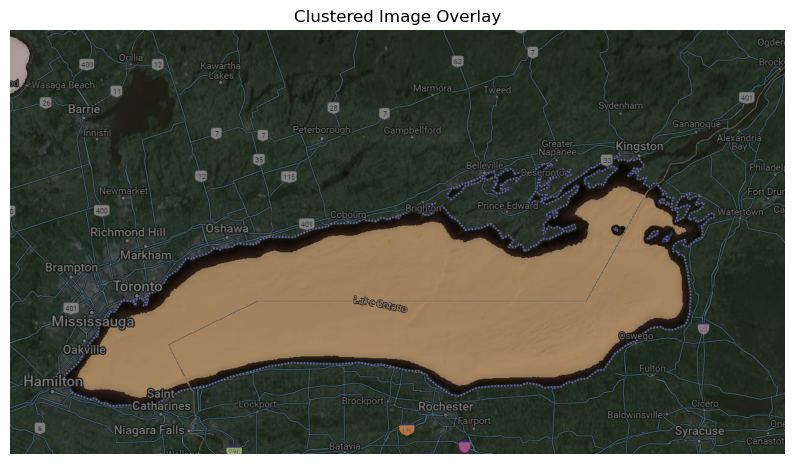

In [118]:
display_clusters(sample_image, water_pixels_df, 'distance_cluster')

In [144]:
def contour_properties(cluster):
    """
    Calculate properties of a cluster to identify geometric characteristics.
    - area: Area covered by the convex hull of the cluster points.
    - compactness: Ratio of the area of the cluster to the area of the convex hull.
    - rectangularity: Ratio of the area of the cluster to the area of the bounding rectangle.
    """
    points = np.array(cluster)
    if len(points) < 3:
        return 0, 0, 0  # Not enough points to form a convex hull or rectangle


    # hull = ConvexHull(points)
    # hull_area = hull.volume
    
    x_min, x_max = np.min(points[:, 0]), np.max(points[:, 0])
    y_min, y_max = np.min(points[:, 1]), np.max(points[:, 1])
    rect_area = (x_max - x_min) * (y_max - y_min)
    
    cluster_area = len(points)
    
    # compactness = cluster_area / hull_area if hull_area > 0 else 0
    rectangularity = cluster_area / rect_area if rect_area > 0 else 0
    
    return cluster_area, rectangularity #, compactness

filtered_clusters_ind = []

for cluster_ind in water_pixels_df['distance_cluster'].unique():
    cluster = water_pixels_df[water_pixels_df['distance_cluster'] == cluster_ind]
    cluster_area, rectangularity = contour_properties(cluster['Position'].to_list())
    print(f"Cluster {cluster_ind}: Area={cluster_area}, Compactness={compactness}, Rectangularity={rectangularity}")
    if cluster_area > 500 and rectangularity > 0.5:
        filtered_clusters_ind.append(cluster_ind)


Cluster -1: Area=26, Compactness=0.26666666666666194, Rectangularity=4.2902874492591e-05
Cluster 0: Area=1912, Compactness=0.26666666666666194, Rectangularity=0.7242424242424242
Cluster 1: Area=5, Compactness=0.26666666666666194, Rectangularity=0.10416666666666667
Cluster 2: Area=6, Compactness=0.26666666666666194, Rectangularity=0.08571428571428572
Cluster 3: Area=166986, Compactness=0.26666666666666194, Rectangularity=0.5298619704902428
Cluster 4: Area=5, Compactness=0.26666666666666194, Rectangularity=0.11904761904761904
Cluster 5: Area=172, Compactness=0.26666666666666194, Rectangularity=0.7226890756302521
Cluster 6: Area=5, Compactness=0.26666666666666194, Rectangularity=1.0
Cluster 7: Area=222, Compactness=0.26666666666666194, Rectangularity=0.6894409937888198
Cluster 8: Area=165, Compactness=0.26666666666666194, Rectangularity=0.6932773109243697
Cluster 9: Area=147, Compactness=0.26666666666666194, Rectangularity=0.7989130434782609


In [103]:
filtered_clusters_ind

[0, 3]

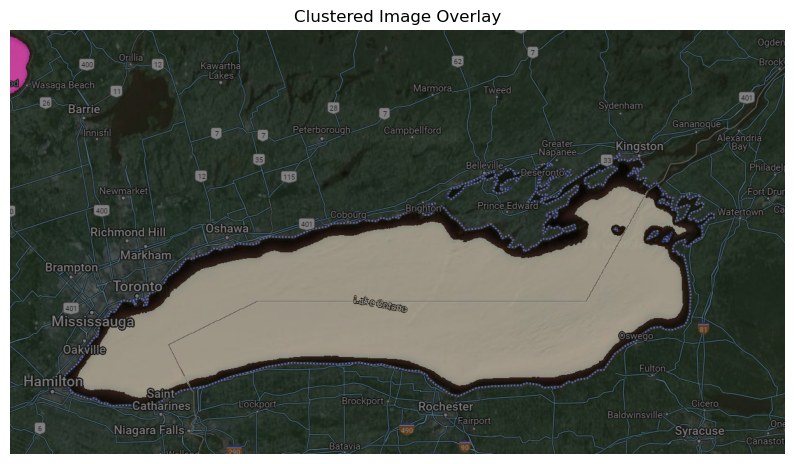

In [119]:
filtered_clusters = water_pixels_df[water_pixels_df['distance_cluster'].isin(filtered_clusters_ind)]
display_clusters(sample_image, filtered_clusters, 'distance_cluster')

In [50]:
sample_image.shape, type(sample_image)

((666, 1217, 3), numpy.ndarray)

### Bad quality image processing

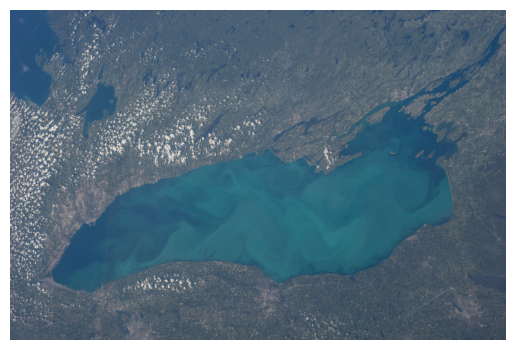

In [120]:
low_quality_path = "low_definition.jpg"
bad_image = cv2.cvtColor(cv2.imread(low_quality_path), cv2.COLOR_BGR2RGB)
plt.imshow(bad_image)
plt.axis('off')
plt.show()

In [123]:
bad_image_reshaped = bad_image / 255.0 # use 0...1 scale
bad_image_reshaped = bad_image_reshaped.reshape(bad_image.shape[0]* bad_image.shape[1], 3)
bad_image_reshaped.shape

(12052992, 3)

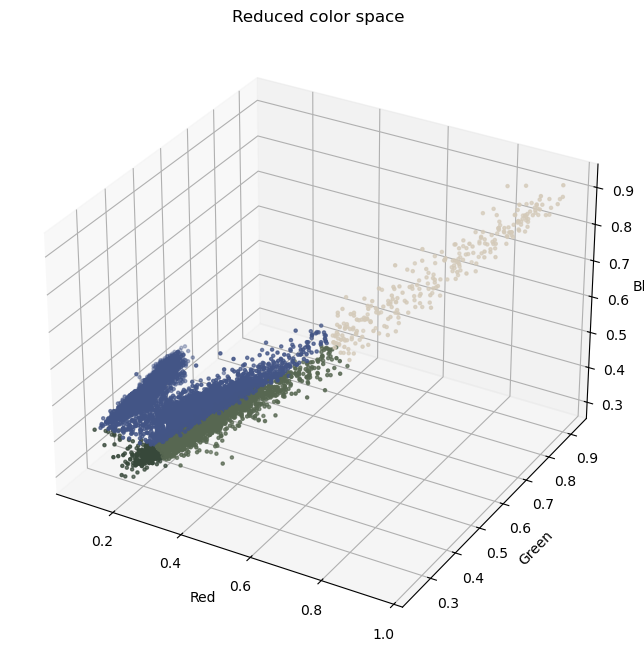

In [129]:
# clusters_amount = 4
# kmeans_dist = KMeans(clusters_amount, random_state=42).fit(sample_image_reshaped)
bad_new_colors = kmeans_dist.cluster_centers_[kmeans_dist.predict(bad_image_reshaped)]

plot_pixels(bad_image_reshaped, colors=bad_new_colors,
            title="Reduced color space")

Text(0.5, 1.0, 'Clustered image')

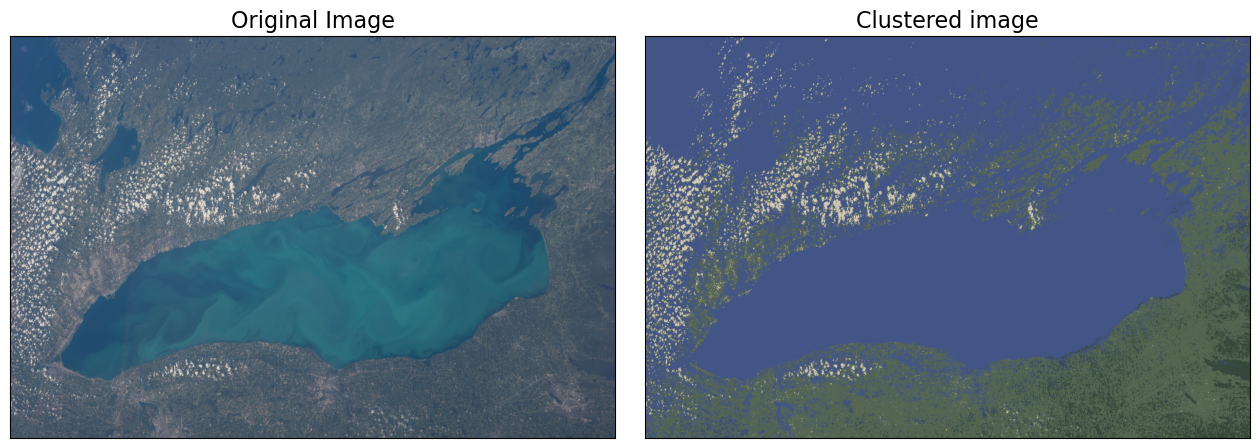

In [130]:
bad_image_color_clust = bad_new_colors.reshape(bad_image.shape)

fig, ax = plt.subplots(1, 2, figsize=(16, 6),subplot_kw=dict(xticks=[], yticks=[]))
fig.subplots_adjust(wspace=0.05)
ax[0].imshow(bad_image)
ax[0].set_title('Original Image', size=16)
ax[1].imshow(bad_image_color_clust)
ax[1].set_title('Clustered image', size=16)

The results are not really good

In [133]:
bad_pixels_df = pd.DataFrame(bad_new_colors)
bad_pixels_df.columns = ['R', 'G', 'B']
bad_pixels_df['Position'] = [[i//bad_image.shape[1], i%bad_image.shape[1]] for i in range(len(bad_pixels_df))]

bad_pixels_df

R         G         B      Position
0         0.262821  0.333526  0.527417        [0, 0]
1         0.262821  0.333526  0.527417        [0, 1]
2         0.262821  0.333526  0.527417        [0, 2]
3         0.262821  0.333526  0.527417        [0, 3]
4         0.262821  0.333526  0.527417        [0, 4]
...            ...       ...       ...           ...
12052987  0.214686  0.282196  0.225828  [2831, 4251]
12052988  0.214686  0.282196  0.225828  [2831, 4252]
12052989  0.214686  0.282196  0.225828  [2831, 4253]
12052990  0.214686  0.282196  0.225828  [2831, 4254]
12052991  0.214686  0.282196  0.225828  [2831, 4255]

[12052992 rows x 4 columns]

In [136]:
bad_mask = bad_pixels_df['R'].apply(lambda x: round(x, 6)==round(kmeans_dist.cluster_centers_[3][0], 6) )
bad_water_pixels_df = bad_pixels_df[bad_mask]
bad_water_pixels_df

R         G         B      Position
0         0.262821  0.333526  0.527417        [0, 0]
1         0.262821  0.333526  0.527417        [0, 1]
2         0.262821  0.333526  0.527417        [0, 2]
3         0.262821  0.333526  0.527417        [0, 3]
4         0.262821  0.333526  0.527417        [0, 4]
...            ...       ...       ...           ...
12052328  0.262821  0.333526  0.527417  [2831, 3592]
12052342  0.262821  0.333526  0.527417  [2831, 3606]
12052343  0.262821  0.333526  0.527417  [2831, 3607]
12052514  0.262821  0.333526  0.527417  [2831, 3778]
12052515  0.262821  0.333526  0.527417  [2831, 3779]

[8003550 rows x 4 columns]

In [137]:
bad_water_pixels_distance = bad_water_pixels_df['Position'].to_list()

In [138]:
bad_clusters_by_dist = dbscan.fit_predict(bad_water_pixels_distance)

bad_water_pixels_df['distance_cluster'] = bad_clusters_by_dist
bad_water_pixels_df

C:\Users\vikto\AppData\Local\Temp\ipykernel_30208\3727304660.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  bad_water_pixels_df['distance_cluster'] = bad_clusters_by_dist


R         G         B      Position  distance_cluster
0         0.262821  0.333526  0.527417        [0, 0]                 0
1         0.262821  0.333526  0.527417        [0, 1]                 0
2         0.262821  0.333526  0.527417        [0, 2]                 0
3         0.262821  0.333526  0.527417        [0, 3]                 0
4         0.262821  0.333526  0.527417        [0, 4]                 0
...            ...       ...       ...           ...               ...
12052328  0.262821  0.333526  0.527417  [2831, 3592]               464
12052342  0.262821  0.333526  0.527417  [2831, 3606]               464
12052343  0.262821  0.333526  0.527417  [2831, 3607]               464
12052514  0.262821  0.333526  0.527417  [2831, 3778]                -1
12052515  0.262821  0.333526  0.527417  [2831, 3779]                -1

[8003550 rows x 5 columns]

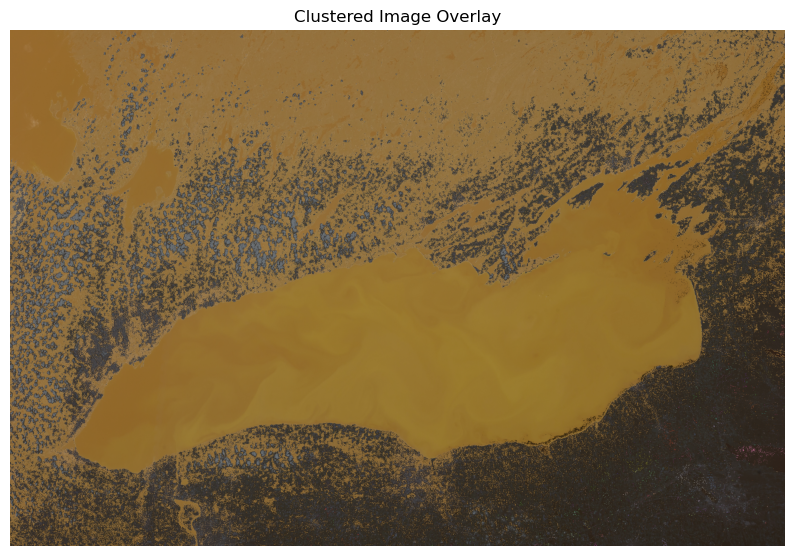

In [139]:
display_clusters(bad_image, bad_water_pixels_df, 'distance_cluster')

In [142]:
len(bad_water_pixels_df['distance_cluster'].unique())

R         G         B      Position  distance_cluster
0         0.262821  0.333526  0.527417        [0, 0]                 0
1         0.262821  0.333526  0.527417        [0, 1]                 0
2         0.262821  0.333526  0.527417        [0, 2]                 0
3         0.262821  0.333526  0.527417        [0, 3]                 0
4         0.262821  0.333526  0.527417        [0, 4]                 0
...            ...       ...       ...           ...               ...
12052328  0.262821  0.333526  0.527417  [2831, 3592]               464
12052342  0.262821  0.333526  0.527417  [2831, 3606]               464
12052343  0.262821  0.333526  0.527417  [2831, 3607]               464
12052514  0.262821  0.333526  0.527417  [2831, 3778]                -1
12052515  0.262821  0.333526  0.527417  [2831, 3779]                -1

[8003550 rows x 5 columns]

In [147]:
filtered_bad_clusters_ind = []

for cluster_ind in bad_water_pixels_df['distance_cluster'].unique():
    cluster = bad_water_pixels_df[bad_water_pixels_df['distance_cluster'] == cluster_ind]
    cluster_area, rectangularity = contour_properties(cluster['Position'].to_list())
    print(f"Cluster {cluster_ind}: Area={cluster_area}, Rectangularity={rectangularity}") #Compactness={compactness},
    if cluster_area > 500 and rectangularity > 0.5: #and compactness > 0.6
        filtered_bad_clusters_ind.append(cluster_ind)

Cluster 0: Area=7986676, Rectangularity=0.6630200055537546
Cluster -1: Area=1348, Rectangularity=0.00015755467661551984
Cluster 1: Area=25, Rectangularity=0.25510204081632654
Cluster 2: Area=74, Rectangularity=0.04868421052631579
Cluster 3: Area=6, Rectangularity=3.0
Cluster 4: Area=7, Rectangularity=0.2916666666666667
Cluster 5: Area=16, Rectangularity=0.2222222222222222
Cluster 6: Area=5, Rectangularity=0.07142857142857142
Cluster 7: Area=5, Rectangularity=0.1
Cluster 8: Area=6, Rectangularity=0.10714285714285714
Cluster 9: Area=9, Rectangularity=0.15
Cluster 10: Area=26, Rectangularity=0.5306122448979592
Cluster 11: Area=252, Rectangularity=0.08974358974358974
Cluster 12: Area=38, Rectangularity=0.07421875
Cluster 13: Area=28, Rectangularity=0.12962962962962962
Cluster 15: Area=5, Rectangularity=0.08928571428571429
Cluster 14: Area=22, Rectangularity=0.07719298245614035
Cluster 16: Area=9, Rectangularity=0.16071428571428573
Cluster 17: Area=15, Rectangularity=0.1171875
Cluster 18: A

In [148]:
filtered_bad_clusters_ind

[0]

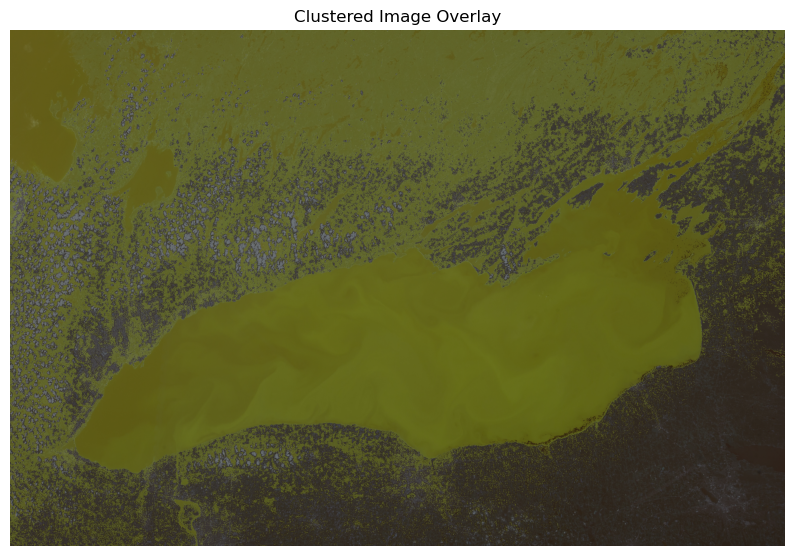

In [149]:
filtered_bad_clusters = bad_water_pixels_df[bad_water_pixels_df['distance_cluster'].isin(filtered_bad_clusters_ind)]
display_clusters(bad_image, filtered_bad_clusters, 'distance_cluster')